## Foreground Removal with PCA

In [140]:
import numpy as np
import matplotlib.pyplot as plt

In [141]:
### LOAD IN THE DATA ###
T_HI = np.load('MultiDarkSims/dT_HI.npy')    #HI intensity map
T_FG = np.load('MultiDarkSims/dT_FG.npy')     #foreground map
nx,ny,nz = np.shape(T_HI)

In [142]:
### MEAN CENTRE AND COMBINE SIMULATED FOREGROUNDS AND SIGNAL ###
T_ALL = T_HI + T_FG
data_array = T_ALL - np.mean(T_ALL)
print(np.mean(data_array))

2.0152747385786393e-11


In [143]:
N = 3             #set number of principal components to consider for foreground

B = np.zeros([nz,N])    #construct selection matrix
for i in range(nz): 
    for j in range(N): 
        if i == j: 
            B[i,j] = 1

In [144]:
### RESHAPE THE DATA AND SWAP AXES ###
axes = np.shape(data_array)
data = np.reshape(data_array,(axes[0]*axes[1],axes[2]))     #reshape data so long 1d array of pixels for each z
data = np.swapaxes(data,0,1)                                #swap axes so that data in form Nz, Npix

### APPLY PCA TO THE DATA
##### This code applies PCA according to the following method: <br/>
1) Find the covariance matrix of the data <br/>
2) Find eigenvalues and vectors of covariance matrix <br/>
3) Construct the mixing matrix, A, by multiplying the eigenvector matrix with the 'selection matrix', whichs selects the eigenvectors associated with components to construct the foreground estimate. <br/>
4) Find the eigen-sources, S, i.e. the projection of the components we want to estimate the foreground with, by multpling the transpose of the mixing matrix with the data. <br/>
5) Finally, construct the foreground matrix by multiplying the mixing matrix and eigensources together. <br/>

In [145]:
cov = np.cov(data)                         #find covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov)    #find eigenvalues and vectors of covariance matrix

A = np.matmul(eig_vecs, B)          #construct mixing matrix
A_trans = A.transpose()             
S = np.matmul(A_trans,data)         #find eigensources #mixing matrix projected onto data

In [146]:
### ESTIMATE FOREGROUND AND REMOVE IT FROM DATA ###
FG_est = np.matmul(A,S)      #estimate foreground

FG_est = np.swapaxes(FG_est,0,1)
FG_est = FG_est.reshape([225,225,225]) 
FG_est = FG_est - np.mean(FG_est)  #add the mean back onto the foreground estimate
print(np.mean(FG_est))

clean = data_array - FG_est  #subtract foreground from data

7.061637805159036e-12


### PLOT THE FOREGROUND ESTIMATES AND CLEANED DATA

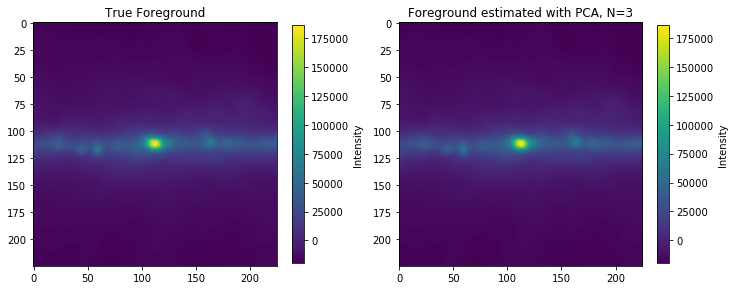

In [147]:
### PLOT TRUE AND ESTIMATED FOREGROUNDS ###
n = 0 #index of map to be plotted from data cube
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(wspace=0.2)

#plot HI intensity map 
dT_FG = T_FG - np.mean(T_FG)
plt.subplot(121)
plt.imshow(dT_FG[:,:,n])
plt.title("True Foreground") #mean centre the foregrounds so that these comparisons are more fair
plt.colorbar(label = "Intensity", shrink = 0.73)

#plot HI intenisty map with foreground
plt.subplot(122)
plt.imshow(FG_est[:,:,n])
plt.title("Foreground estimated with PCA, N="+str(N))
plt.colorbar(label="Intensity", shrink = 0.73)
plt.savefig("plots/test.png")                  #change filename

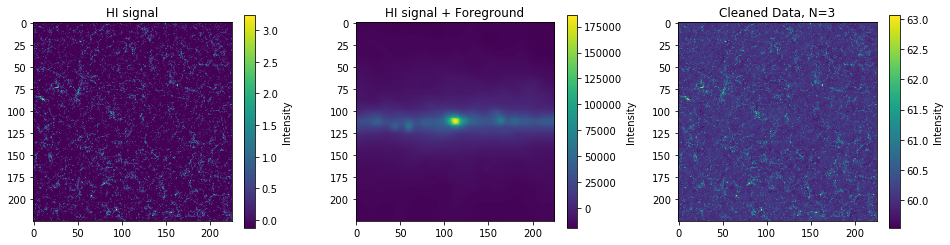

In [154]:
### PLOT HI SIGNAL, SIGNAL + DATA AND CLEANED DATA ###

n = 0 #index of map to be plotted from data cube
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(wspace=0.3)

#plot HI intensity map 
plt.subplot(131)
plt.imshow(T_HI[:,:,n])
plt.title("HI signal")
plt.colorbar(label = "Intensity", shrink = 0.49)

#plot HI intenisty map with foreground
plt.subplot(132)
plt.imshow(data_array[:,:,n])
plt.title("HI signal + Foreground")

plt.colorbar(label="Intensity", shrink = 0.49)

#plot cleaned data
plt.subplot(133)
plt.imshow(clean[:,:,n])
plt.title("Cleaned Data, N="+ str(N))
plt.colorbar(label = "Intensity", shrink = 0.49)


plt.savefig("plots/test.png")                       #change filename

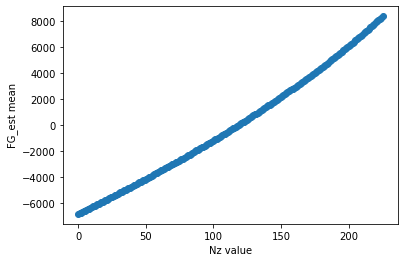

In [149]:
### PLOT MEAN VALUES OF ESTIMATED FOREGROUND
fg_mean = np.zeros(nz)
for i in range(nz): 
    r_mean = np.mean(FG_est[:,:,i])
    fg_mean[i] = r_mean

x = np.linspace(0,225,num=225)

plt.scatter(x,fg_mean)
plt.xlabel("Nz value")
plt.ylabel("FG_est mean")
plt.show()

### FIND RESIDUALS OF CLEANED DATA

In [150]:
resids = T_HI - clean 

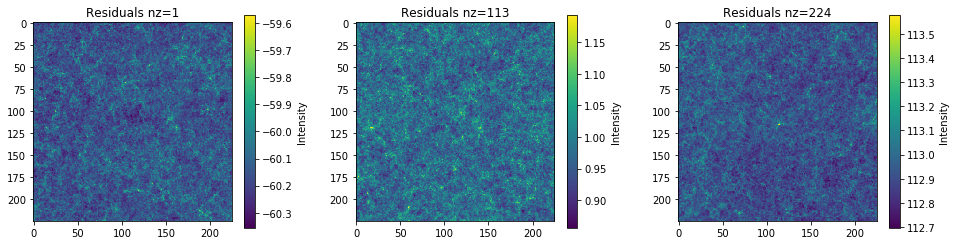

In [151]:
### PLOT RESIDUALS FOR VARIOUS Nz VALUES ###

fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(wspace=0.3)

#Nz = 0 
plt.subplot(131)
plt.imshow(resids[:,:,0])
plt.title("Residuals nz=1")

plt.colorbar(label = "Intensity", shrink = 0.49)

#Nz = 113
plt.subplot(132)
plt.imshow(resids[:,:,112])
plt.title("Residuals nz=113")
plt.colorbar(label="Intensity", shrink = 0.49)

#Nz = 224
plt.subplot(133)
plt.imshow(resids[:,:,224])
plt.title("Residuals nz=224")
plt.colorbar(label = "Intensity", shrink = 0.49)

plt.savefig("plots/test.png")                       #change filename

In [152]:
#find mean residual for each frequency value and plot these as a function of frequecny value 
resid_mean = np.zeros(nz)
for i in range(nz): 
    r_mean = np.mean(resids[:,:,i])
    resid_mean[i] = r_mean

x = np.linspace(0,225,num=225)

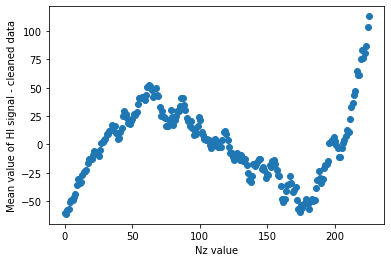

In [153]:
### PLOT MEAN RESIDUAL VALUE AS A FUNCTION OF Nz VALUE ###This
plt.scatter(x,resid_mean)
#plt.title("Average difference between True signal and cleaned data as a function of nz")
plt.xlabel("Nz value")
plt.ylabel("Mean value of HI signal - cleaned data")
plt.show()